<a href="https://colab.research.google.com/github/hypro2/LLM-Multimodal-Colab/blob/main/phi2clip_multimodal_train_fail_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/Delve-ERAV1/Phi-2-Vision-Language

In [ ]:
!pip install -U -q transformers accelerate bitsandbytes
!pip install -q pillow
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 58.9 MB/s eta 0:00:00


In [ ]:
!git clone https://huggingface.co/datasets/BUAADreamer/pokemon-gpt4-1k/

Cloning into 'pokemon-gpt4-1k'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 11), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (31/31), 51.57 KiB | 2.34 MiB/s, done.
fatal: destination path 'pokemon-gpt4-1k' already exists and is not an empty directory.


In [ ]:
import json
import pandas as pd

import glob2
import torch
import lightning.pytorch as pl
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import random_split, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor

import numpy as np
from PIL import Image
import io

import torch.nn as nn
from torch.nn import functional as F
from lightning.pytorch import LightningModule
from transformers import AutoModelForCausalLM, CLIPVisionModel, AutoTokenizer

In [ ]:
# Parquet 파일 읽기
df = pd.read_parquet('/content/pokemon-gpt4-1k/data/train-00000-of-00001.parquet')

In [ ]:
torch.multiprocessing.set_start_method('spawn')

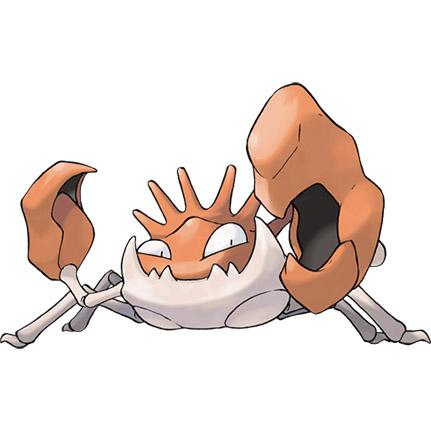

In [ ]:
images = []
for i in range(len(df)):
    image_bytes = df['images'][i][0]['bytes']
    image = Image.open(io.BytesIO(image_bytes))
    images.append(image)

# 이미지 표시
image

In [ ]:
df.head()

,messages,images
0,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
1,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
2,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
3,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
4,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...


In [ ]:
print(df['messages'][0][0])
print(df['messages'][0][1])

{'role': 'user', 'content': 'Provide caption for the image in one sentence. Be detailed but precise.'}
{'role': 'assistant', 'content': 'A cheerful Bulbasaur ready for its next Pokémon adventure.'}


In [ ]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# from transformers import AutoProcessor, CLIPVisionModel

# clip_model_name = "openai/clip-vit-base-patch32"
# vision_model = CLIPVisionModel.from_pretrained(clip_model_name)
# processor  = AutoProcessor.from_pretrained(clip_model_name)

# vision_model = vision_model.to("cuda")

In [ ]:
# import torch

# image_inputs = processor(
#     images=[image],
#     return_tensors="pt",
#     do_resize=True,
#     size={"height": 384, "width": 384},
# ).to("cuda")

# image_inputs = image_inputs["pixel_values"].squeeze(0)

# with torch.no_grad():
#     image_forward_outs = vision_model(image_inputs.to(device="cuda", dtype=torch.float16).unsqueeze(0), output_hidden_states=True,)

# image_features = image_forward_outs.hidden_states[-2]
# image_features

In [ ]:
torch.set_default_device("cuda")

In [ ]:
clip_model_name = "openai/clip-vit-base-patch32"
phi_model_name = "microsoft/phi-1_5"

class CLIPPhi2Model(LightningModule):
    def __init__(self, clip_embed=768, phi_embed=2048):
        super().__init__()

        self.EOS_TOKEN_ID = 50256
        self.IMAGE_TOKEN_ID = 50293

        self.tokenizer = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
        self.clip_model = CLIPVisionModel.from_pretrained(clip_model_name)
        self.phi2_model = AutoModelForCausalLM.from_pretrained(phi_model_name,
                                                               torch_dtype=torch.float32,
                                                               trust_remote_code=True)

        self.projection = PatchReducerWithProjections(49, 30, clip_embed, phi_embed)

        # Freeze Weights
        for network in [self.phi2_model, self.clip_model]:
            for param in network.parameters():
                param.requires_grad_(False)

    def forward(self, images, target_captions, use_teacher_forcing):
        batch_size = target_captions.size(0)
        target_length = target_captions.shape[1]

        clip_outputs = self.clip_model(**images)
        images = clip_outputs.last_hidden_state[:, 1:, :]

        image_embeds = self.projection(images)

        num_patches = image_embeds.size(1)
        image_embeds_flat = image_embeds.view(batch_size, num_patches, -1)

        image_tokenized = torch.tensor(self.IMAGE_TOKEN_ID).repeat(batch_size, 1)
        image_token_embed = self.phi2_model.model.embed_tokens(image_tokenized.to(image_embeds.device))

        combined_embeds = torch.zeros(batch_size, target_length + num_patches + 1, image_embeds.shape[-1], device=image_embeds.device)

        combined_embeds[:, :num_patches, :].copy_(image_embeds_flat)
        combined_embeds[:, num_patches, :].copy_(image_token_embed.squeeze(1))
        logits_history = torch.empty((batch_size, target_length - 1, self.phi2_model.config.vocab_size), device=combined_embeds.device)

        for t in range(num_patches+1, target_length+num_patches):
            combined_embeds_slice = combined_embeds[:, :t, :].clone()

            outputs = self.phi2_model(inputs_embeds=combined_embeds_slice)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]

            next_step_logits = logits[:, -1, :].unsqueeze(1)
            logits_history[:, t - (num_patches+1), :] = next_step_logits.squeeze(1)

            sampling_rate = scheduled_sampling_rate(self.global_step, self.trainer.estimated_stepping_batches)
            if use_teacher_forcing and torch.rand(1).item() <= sampling_rate:
                next_token = target_captions[:, t-(num_patches+1)]
            else:
                next_token = torch.argmax(next_step_logits, dim=-1)

            next_token_embeds = self.phi2_model.model.embed_tokens(next_token)
            combined_embeds[:, t, :].copy_(next_token_embeds.squeeze(1))

        del combined_embeds
        del clip_outputs
        del image_embeds
        del image_embeds_flat
        del next_token_embeds
        del images
        torch.cuda.empty_cache()
        return logits_history


    def common_step(self, batch, use_teacher_forcing):
        images, target_captions = batch
        images = {'pixel_values': images}
        outputs = self.forward(images, target_captions, use_teacher_forcing)
        loss = F.cross_entropy(outputs.view(-1,outputs.size(-1)), target_captions[:, 1:].contiguous().view(-1), ignore_index=self.EOS_TOKEN_ID)
        return(loss)

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, use_teacher_forcing=True)
        self.log(f"train/loss", loss.item(), prog_bar=True, on_step=True, logger=True)

        if self.global_step % 400 == 0:
            self.evaluate_model_performance(batch)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch, use_teacher_forcing=False)
        self.log(f"val/loss", loss.item(), prog_bar=True, on_step=True, logger=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=1e-4)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=1e-3,
            pct_start=0.05,
            total_steps=self.trainer.max_steps,
            anneal_strategy='cos',
            div_factor=100,
            final_div_factor=1000,
        )
        return {'optimizer': optimizer,
                'lr_scheduler': {'scheduler': scheduler, 'interval': 'step'}}

    def on_save_checkpoint(self, checkpoint):

        keys = checkpoint['state_dict'].keys()
        keys = [k for k in keys if 'projection' not in k]

        for k in keys:
            del checkpoint['state_dict'][k]

    def evaluate_model_performance(self, batch):
        images, target_captions = batch
        images = {'pixel_values': images}
        batch_size = target_captions.size(0)

        # Forward pass through the model
        logits = self.forward(images, target_captions, use_teacher_forcing=False)
        predictions = torch.argmax(logits, dim=-1)

        # Iterate over each item in the batch
        for i in range(batch_size):
            print(f"Image {i+1}:")

            # Ground Truth
            ground_truth_caption = self.tokenizer.decode(target_captions[i], skip_special_tokens=True)
            print(f"Ground Truth: {ground_truth_caption}")

            # Model Prediction
            predicted_caption = self.tokenizer.decode(predictions[i], skip_special_tokens=True)
            print(f"Predicted: {predicted_caption}")
            print("---------------------------------------------------")


class PatchReducerLinear(nn.Module):
    def __init__(self, num_patches, reduced_num_patches):
        super().__init__()
        self.reducer = nn.Linear(num_patches, reduced_num_patches)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.reducer(x)
        x = x.permute(0, 2, 1)
        return x


class PatchReducerAvgPool(nn.Module):
    def __init__(self, pool_size):
        super().__init__()
        self.pool = nn.AvgPool1d(kernel_size=pool_size, stride=pool_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        return x


class PatchReducerWithProjections(nn.Module):
    def __init__(
        self,
        num_patches,
        reduced_num_patches,
        clip_embed,
        phi_embed,
        num_projection_layers=4,
        num_experts=6,
    ):
        super().__init__()

        self.moe = MixtureOfExperts(clip_embed, num_experts)
        self.output = nn.Linear(clip_embed, phi_embed)
        self.projection_layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(clip_embed, clip_embed),
                    nn.GELU(),
                    nn.Linear(clip_embed, clip_embed),
                )
                for _ in range(num_projection_layers)
            ]
        )

    def forward(self, x):

        # x = x.permute(0, 2, 1)
        # x = self.patch_reducer(x)
        # x = x.permute(0, 2, 1)
        x = self.moe(x)
        for layer in self.projection_layers:
            residual = x
            x = layer(x) + residual
        x = self.output(x)
        return x


def scheduled_sampling_rate(epoch, max_epochs, start_rate=1.0, end_rate=0.0, decay='exponential'):
    if decay == 'linear':
        return start_rate - (start_rate - end_rate) * (epoch / max_epochs)
    elif decay == 'exponential':
        return start_rate * (end_rate / start_rate) ** (epoch / max_epochs)
    elif decay == 'inverse_sigmoid':
        return end_rate + (start_rate - end_rate) * (max_epochs / (max_epochs + np.exp(epoch / max_epochs)))



class MixtureOfExperts(nn.Module):
    def __init__(self, embed, num_experts):
        super().__init__()
        self.experts = nn.ModuleList([nn.Linear(embed, embed) for _ in range(num_experts)])
        self.gating = nn.Linear(embed, num_experts)

    def forward(self, x):
        gates = torch.softmax(self.gating(x), dim=-1).unsqueeze(-1)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2)
        output = torch.sum(gates*expert_outputs, dim=2)
        return output

class SparseMixtureOfExperts(nn.Module):
    def __init__(self, embed, num_experts, k=2):
        super().__init__()
        self.experts = nn.ModuleList([nn.Linear(embed, embed) for _ in range(num_experts)])
        self.gating = nn.Linear(embed, num_experts)
        self.k = k

    def forward(self, x):
        gates = torch.softmax(self.gating(x), dim=-1)
        topk_indices = torch.topk(gates, k=self.k, dim=-1).indices

        active_experts = [self.experts[i.item()] for i in topk_indices.view(-1)]
        expert_outputs = torch.stack([expert(x) for expert in active_experts], dim=1)  # Corrected stacking dimension

        active_gates = gates.gather(-1, topk_indices)

        output = torch.sum(active_gates.unsqueeze(-2) * expert_outputs, dim=2)
        return output

In [ ]:

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import json
import torch
from PIL import Image
from torch.utils.data import Dataset
from lightning.pytorch import LightningDataModule
from transformers import AutoProcessor, AutoTokenizer
from torch.utils.data import random_split, DataLoader


class llavadataset(Dataset):
  def __init__(self, df, phi_model_name, clip_model_name):

    self.tokenizer  = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
    self.processor  = AutoProcessor.from_pretrained(clip_model_name)
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    df = self.df.iloc[idx]
    image_bytes = df['images'][0]['bytes']
    img = Image.open(io.BytesIO(image_bytes))
    image_processed = self.processor(images=img, return_tensors="pt")['pixel_values']
    image_processed = image_processed.squeeze(0)

    a = self.tokenizer(df['messages'][1]['content'], return_tensors="pt", return_attention_mask=False)
    return(image_processed , a['input_ids'].squeeze(0).cuda())


def collate_fn(batch):
    image_embeddings, captions = zip(*batch)
    image_embeddings_stacked = torch.stack(image_embeddings, dim=0)

    # Pad the captions to the same length
    captions_padded = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=50256)
    return (image_embeddings_stacked, captions_padded)

In [ ]:
batch_size = 1
num_workers = 0

phi_model_name = "microsoft/phi-1"
clip_model_name = "openai/clip-vit-base-patch32"

train_dataset = llavadataset(df, phi_model_name, clip_model_name)

train_dataloader = DataLoader(train_dataset,
                              collate_fn=collate_fn, batch_size=batch_size,
                              shuffle=True, pin_memory=False, generator=torch.Generator(device="cuda"))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
train_dataset[0]

(tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],
 
         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],
 
         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ...,

In [ ]:
MModalGPT = CLIPPhi2Model().to("cuda")
MModalGPT

`low_cpu_mem_usage` was None, now set to True since model is quantized.


CLIPPhi2Model(
  (clip_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              

In [ ]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="train/loss",
    mode="min",
    dirpath="model-checkpoint/",
    filename="MModalGPT-{step:02d}-{train/loss:.2f}",
    every_n_train_steps=100
)

trainer = pl.Trainer(log_every_n_steps=1,
                     enable_model_summary=True,
                     max_steps=100,
                     accelerator='auto',
                     devices='auto',
                     callbacks=[checkpoint_callback, LearningRateMonitor(logging_interval="step")]
                    )

# torch.set_float32_matmul_precision('medium')
trainer.fit(MModalGPT, train_dataloader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                        | Params
-----------------------------------------------------------
0 | clip_model | CLIPVisionModel             | 87.5 M
1 | phi2_model |

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 43.06 MiB is free. Process 214646 has 14.70 GiB memory in use. Of the allocated memory 14.14 GiB is allocated by PyTorch, and 445.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)